## Simple Dask example: F-1 results
How to read, join and aggregate data in CSV files using Pandas.  
- Kaggle datase "[Formula 1 Race Data](https://www.kaggle.com/cjgdev/formula-1-race-data-19502017)" is used 
  - download extract the zip file
  - place file to a location visible from the container and set relative file locations of `read_csv()`
- We would like to know which drivers spent the most time racing, and check distribution of the aggregated race times of the drivers. 

In [1]:
import matplotlib.pyplot as plt
import dask.dataframe as dd

### Read relevant CSV files

In [2]:
drivers_df = dd.read_csv("../../formula-1-race-data/drivers.csv", encoding="latin1")
drivers_df.head(10)

driverId   driverRef  number code    forename      surname         dob  \
0         1    hamilton    44.0  HAM       Lewis     Hamilton  07/01/1985   
1         2    heidfeld     NaN  HEI        Nick     Heidfeld  10/05/1977   
2         3     rosberg     6.0  ROS        Nico      Rosberg  27/06/1985   
3         4      alonso    14.0  ALO    Fernando       Alonso  29/07/1981   
4         5  kovalainen     NaN  KOV      Heikki   Kovalainen  19/10/1981   
5         6    nakajima     NaN  NAK      Kazuki     Nakajima  11/01/1985   
6         7    bourdais     NaN  BOU  SÌ©bastien     Bourdais  28/02/1979   
7         8   raikkonen     7.0  RAI        Kimi  RÌ_ikkÌ¦nen  17/10/1979   
8         9      kubica     NaN  KUB      Robert       Kubica  07/12/1984   
9        10       glock     NaN  GLO        Timo        Glock  18/03/1982   

  nationality                                                url  
0     British        http://en.wikipedia.org/wiki/Lewis_Hamilton  
1      German         http://en.wikipedia.org/wiki/Nick_Heidfeld  
2      German          http://en.wikipedia.org/wiki/Nico_Rosberg  
3     Spanish       http://en.wikipedia.org/wiki/Fernando_Alonso  
4     Finnish     http://en.wikipedia.org/wiki/Heikki_Kovalainen  
5    Japanese       http://en.wikipedia.org/wiki/Kazuki_Nakajima  
6      French  http://en.wikipedia.org/wiki/S%C3%A9bastien_Bo...  
7     Finnish  http://en.wikipedia.org/wiki/Kimi_R%C3%A4ikk%C...  
8      Polish         http://en.wikipedia.org/wiki/Robert_Kubica  
9      German            http://en.wikipedia.org/wiki/Timo_Glock

In [3]:
lap_times_df = dd.read_csv("../../formula-1-race-data/lapTimes.csv")
lap_times_df.head(10)

raceId  driverId  lap  position      time  milliseconds
0     841        20    1         1  1:38.109         98109
1     841        20    2         1  1:33.006         93006
2     841        20    3         1  1:32.713         92713
3     841        20    4         1  1:32.803         92803
4     841        20    5         1  1:32.342         92342
5     841        20    6         1  1:32.605         92605
6     841        20    7         1  1:32.502         92502
7     841        20    8         1  1:32.537         92537
8     841        20    9         1  1:33.240         93240
9     841        20   10         1  1:32.572         92572

### Sum up lap times of drivers
- project on relevant columns, group by driverId, sum times in milliseconds
- draw histogram of times
- filter drivers over 100 hours
- add time values in hours

In [8]:
times_sum_df = lap_times_df[['driverId', 'milliseconds']].groupby(['driverId']).sum() 

#    .set_index('milliseconds', sorted=True)
# sorting might be complicated with dask, there is no sort_values function

times_sum_df['hours'] = times_sum_df['milliseconds'] / (1000*60*60)
times_sum_df.head(10)

milliseconds       hours
driverId                          
1           1142081867  317.244963
2            897483927  249.301091
3           1099210312  305.336198
4           1513292145  420.358929
5            600807739  166.891039
6            187543808   52.095502
7            121312197   33.697832
8           1328518217  369.032838
9            402912254  111.920071
10           483534152  134.315042

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc42e7f1860>]],
      dtype=object)

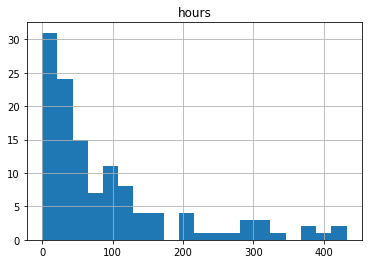

In [11]:
# compute() converts Dask dataframes to Pandas dataframes - there are no histograms directly in Dask
times_sum_df.compute().hist(column='hours', bins=20)

In [12]:
top_times_sum_df = times_sum_df[times_sum_df['hours']>=100]

### Join driver data
and display toplist as a barchart 

In [14]:
top_times_sum_df = dd.merge(top_times_sum_df, drivers_df, on='driverId')

In [15]:
top_times_sum_df.head(10)

driverId  milliseconds       hours   driverRef  number code  forename  \
0         1    1142081867  317.244963    hamilton    44.0  HAM     Lewis   
1         2     897483927  249.301091    heidfeld     NaN  HEI      Nick   
2         3    1099210312  305.336198     rosberg     6.0  ROS      Nico   
3         4    1513292145  420.358929      alonso    14.0  ALO  Fernando   
4         5     600807739  166.891039  kovalainen     NaN  KOV    Heikki   
5         8    1328518217  369.032838   raikkonen     7.0  RAI      Kimi   
6         9     402912254  111.920071      kubica     NaN  KUB    Robert   
7        10     483534152  134.315042       glock     NaN  GLO      Timo   
8        11     410349750  113.986042        sato     NaN  SAT    Takuma   
9        13    1429686930  397.135258       massa    19.0  MAS    Felipe   

       surname         dob nationality  \
0     Hamilton  07/01/1985     British   
1     Heidfeld  10/05/1977      German   
2      Rosberg  27/06/1985      German   
3       Alonso  29/07/1981     Spanish   
4   Kovalainen  19/10/1981     Finnish   
5  RÌ_ikkÌ¦nen  17/10/1979     Finnish   
6       Kubica  07/12/1984      Polish   
7        Glock  18/03/1982      German   
8         Sato  28/01/1977    Japanese   
9        Massa  25/04/1981   Brazilian   

                                                 url  
0        http://en.wikipedia.org/wiki/Lewis_Hamilton  
1         http://en.wikipedia.org/wiki/Nick_Heidfeld  
2          http://en.wikipedia.org/wiki/Nico_Rosberg  
3       http://en.wikipedia.org/wiki/Fernando_Alonso  
4     http://en.wikipedia.org/wiki/Heikki_Kovalainen  
5  http://en.wikipedia.org/wiki/Kimi_R%C3%A4ikk%C...  
6         http://en.wikipedia.org/wiki/Robert_Kubica  
7            http://en.wikipedia.org/wiki/Timo_Glock  
8           http://en.wikipedia.org/wiki/Takuma_Sato  
9          http://en.wikipedia.org/wiki/Felipe_Massa

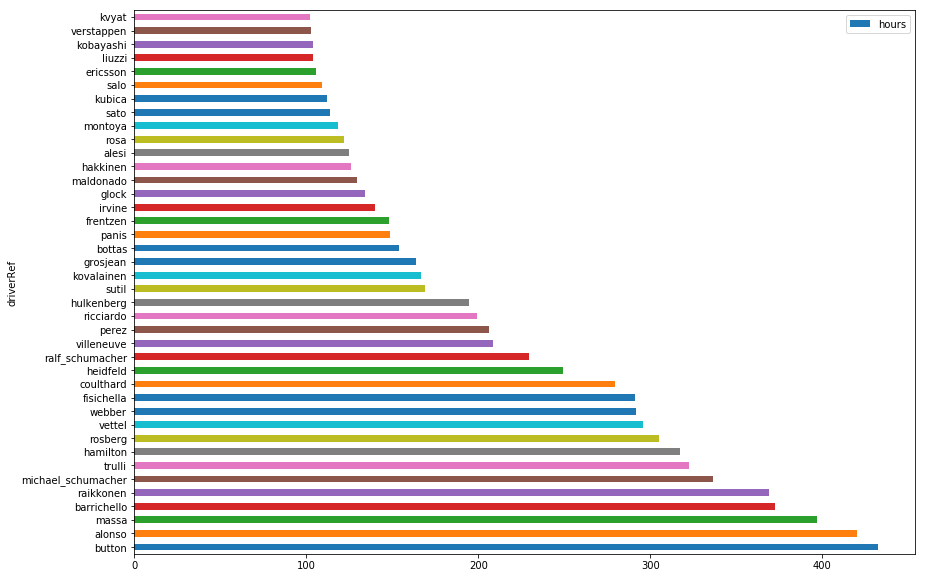

In [17]:
top_times_sum_df.compute().sort_values(by=['milliseconds'], ascending=False) \
    .plot.barh(y='hours', x='driverRef', figsize=(14,10))